In [1]:
import glob
import json
import matplotlib.pyplot as plt
import mrmr

import numpy as np
import os
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
import re
import seaborn as sns
import umap
import xgboost as xgb


import re
import requests
import urllib
import pathlib

from IPython.display import display,HTML
from pprint import pprint

from sklearn.preprocessing import (
    MaxAbsScaler,
    MinMaxScaler,
    RobustScaler,
    StandardScaler,
)

from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import (
    auc,
    classification_report, 
    confusion_matrix, 
    recall_score, 
    precision_score, 
    f1_score,
    roc_curve, 
    roc_auc_score, 
    RocCurveDisplay,
    accuracy_score
)

from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, Lasso, LassoCV

from sklearn.naive_bayes import MultinomialNB

%matplotlib inline

### Executive Summary

The goal of this notebook is to use a combination of clinical, genetic, and transcriptomic data as inputs to ML models in order to better understand 1) predictive factors of a patient's overall survival (supervised ML) in Non-small-cell lung cancer (NSCLC)  and 2) identifying underlying patterns and/or attributes that are either shared or unique to each NSCLC subtype included here, LUAD and LUSC. 

### Highlights of Procedure

To achieve goal 1, I mainly tested a RandomForestClassifier (RFC) wrapped in a GridSearchCV and Sklearn Pipeline. RFC is not sensitive to scaling of features, and can accomodate lots of different kinds of features over different ranges. While an RFC can be prone to overfitting, setting some key parameters like `max_depth` and `max_features` can help to avoid overfitting.

I compared the following strategies: 1) manual feature subsetting, 2) Principal Componenet Analysis (PCA), a linear dimensionality reduction technique, and 3) Uniform Manifold Approximation and Projection (UMAP), a non-linear dimension reduction algorithm. These strategies were applied to: 1) clinical data only; 2) genetic data only; 3) transcriptomic data only; 4) a combination of genetic+transcriptomic data.     

Some next steps for this analysis include: 1) Testing more models than an RFC like XGB (I did start testing out the XGB but ran into some bugs where (I think) the input data matrix was so sparse, XGB could not load the trained model properly for the test set because it would drop some features (similar to [this bug](https://github.com/dmlc/xgboost/issues/1238)); 2) Doing some additional feature selection with more in-depth differential gene expression analysis and minimum Redundancy - Maximum Relevance feature selection; 3) more in-depth correlation testing to see if I could drop some highly correlated features that may be more biologically meaningful than the PCA/UMAP transformations. 

### Highlights of Findings
-Clinical features could predict OS_STATUS with ~75% accuracy (and predicted LUSC v. LUAD subtypes with 100% accuracy, the subtype model was significantly overfit)
-Genetic mutations alone could not predict OS_STATUS much better than chance, and performance degraded when PCA was applied. My interpretation of these findings is that many genetic mutations are contributing to OS_STATUS differences but each is doing so just a little bit. Polygenic Risk Score analysis would be super interesting here! 

### Brief Overview of Tasks

Throughout this exercise we are focused on lung adenocarcinoma (LUAD) and lung squamous cell carcinoma (LUSC), two of the most common subtypes of lung cancer. LUAD and LUSC are treated similarly and both grouped together as non-small cell lung cancer (NSCLC), despite having very different biological signatures. Input data was generated as part of the [PanCanAtlas](https://gdc.cancer.gov/about-data/publications/pancanatlas) project and can be found on cBioPortal, TGCA, and others. We focus on a subset of these data, namely transcriptomic data, somatic mutation calls data, and clinical attributes from both patients and samples. 

Part 1 of this notebook covers 3 phases: A) Data Ingest, B) Processing, and C) Basic Analysis (Exploratory Data Analysis (EDA), and preliminary machine learning analyses.

As part of the Data Ingest phase, I will use `glob`, `os`, and `pandas` to manually parse the downloaded files. I tested out both the native cBioPortal API and the cBio_py wrapper to retrieve these data, but ultimately bulk retrieval of mutation data is not a supported use case at this time (see [here](https://groups.google.com/g/cbioportal/c/TLmBHuxPtVY/m/nSkiupyAAgAJ) and [here](https://groups.google.com/g/cbioportal/c/yXnikDNyONk/m/2284WSNwCAAJ])).
    
* [LUAD data source](https://www.cbioportal.org/study/summary?id=luad_tcga_pan_can_atlas_2018)
* [LUSC data source](https://www.cbioportal.org/study/summary?id=lusc_tcga_pan_can_atlas_2018)


In [2]:
def grab_cBio_data(raw_data_location):
    ''' This function accepts a file path containing a cBioPortal dataset
    and organizes it into a dictionary of dictionaries.
    Each dictionary contains a Pandas dataframe keyed by the data label given in the filename.
    For example, 'data_rppa.txt' is keyed as rppa. Right now this function only looks at data_
    files but could be modified to also push back any associated metadata (from meta_ files)
    
    Arguments:
        raw_data_loc (str): the file path of the folder containing the downloaded cBio Dataset

    Returns:
        raw_data_dict: a dictionary of Pandas Dataframes   '''
    raw_data_dict = {}
    data_files = glob.glob(raw_data_location+"/*")

    for f in data_files:
        if os.path.isfile(f) and 'data_' in f:
            key1 = os.path.basename(f).split('_')[-1].split('.')[0]
            table = pd.read_table(f,comment='#',header='infer',low_memory=False)
            raw_data_dict[key1] = table

    return raw_data_dict

In [3]:
def report_cbio_data_ingest(raw_data_dict):
    ''' This function accepts a raw_data_dict and prints out
    how much data was scraped successfully.
    Sorts by data categories (clinical data, metadata, case data, etc.),
    reports shape of each inner dataframe.

    Arguments:
        raw_data_dict (dict): a dictionary of dictionaries of Pandas dataframes

    Returns:
        nothing, produces a print-out   '''

    print("DATA INGEST REPORT")
    for k,v in raw_data_dict.items():
        print(f"DATA CATEGORY: {k}")
        print(' ' * 2, f"VALUES: {v.shape}")
    print("*" * 20)

In [4]:
def impute_helper(df,groupby_list,col_to_impute,agg='median'):
    '''Quick helper function to simply grab the median (or other agg function) by attributes to groupby.
    For example, I noticed that the ANEUPLOIDY_SCORE median was different across many of the LUSC subtypes,
    and I wanted to capture those differences. So this function is used to impute the median from the subtype, 
    instead of the overall column/feature median'''
    return df.groupby([groupby_list])[col_to_impute].transform(agg)

In [5]:
def check_missing_data(df):
    '''Quick view of missing data in df, returns df populated with percentage of missing values
    Arguments:
        df (df): the df to check

    Returns:
        missing_data: a df that shows each data column and the %age of missing data'''
    missing_data = (pd.DataFrame(data=df.isna().mean() * 100,
               columns=['Percent_Missing']) \
               .sort_values(by='Percent_Missing', ascending=False)
               )
    return missing_data

In [6]:
def clean_mutations(mut_data):
    '''This function takes the raw mutation table from data_mutations.txt and pivots it such that
    #the index becomes the Hugo Symbol, the columns are each sample (Tumor_Sample_Barcode), and the 
    cells are the counts of each of the Variant Classification values -- so if there are 2 mutations
    in a specific Hugo symbol for one patient, the cell would be encoded as 2. This function does not
    take into account different Variant Classifications (so if there were 2 FS and 2 SNPs, the count would be 
    reported as 4). 
    
    Arguments:
        mut_data (df): the df containing the mutation data to pivot

    Returns:
        a pivoted version, where each row is a Hugo Symbol and each column a patient sample  '''
    return (mut_data.pivot_table(index='Hugo_Symbol',
                                 columns='Tumor_Sample_Barcode',
                                 values='Variant_Classification',
                                 aggfunc='count') \
            .fillna(0).astype(int).T
            )

In [7]:
def clean_patient_data(patient_data):
    '''This function is the helper to clean all the patient data, in this case from either LUAD or LUSC types.
    Major highlights: 
    -uses str.contains + .loc to subset columns of interest (features),
    -standardizes PRIOR_DX responses using str.contains
    -replaces binary categorical data with numerical values
    -fills NaNs in SUBTYPE (which is the same value as CANCER_TYPE_ACRONYM)
    -uses pd.get_dummies to encode categorical values (selected via regex to include PATH stages + AJCC staging)
    
    Arguments:
        patient_data (df): the df containing the raw patient data 

    Returns:
        cleaned: a cleaned version of patient data'''
    
    print("Working on patient dataframe....")
    #first, drop cols with > 30% data missing
    intermed = patient_data.dropna(thresh = .7 * patient_data.shape[0],axis=1)
    print(f"Dropped {patient_data.shape[1] - intermed.shape[1]} columns due to missing data ")

    #next, drop admin data that do not appear to be relevant features 
    #as well as DFS and PFS-based columns (I only want OS_MONTHS and OS_STATUS)
    
    intermed = intermed.loc[:,~intermed.columns.str.contains('other|ethnicity|lymph|race|days|icd|form|pfs|dss|dfs|freeze|weight',flags=re.IGNORECASE)]

    #also drop any NaNs from cols that would not be imputed here (AGE and target OS_MONTHS)
    intermed = intermed.dropna(axis=0,how='any',subset=['AGE','OS_MONTHS'])

    #there are 9 rows in LUAD that have a non-standardized entry in PRIOR_DX 
    #("Yes, History Of Synchronous And Or Bilateral Malignancy") so I explicitly reassign values 
    #if the str contains 'yes'

    intermed.loc[(~intermed['PRIOR_DX'].isna()) & (intermed['PRIOR_DX'].str.contains('Yes')), 'PRIOR_DX'] = 'Yes'
    intermed.loc[(~intermed['PRIOR_DX'].isna()) & (intermed['PRIOR_DX'].str.contains('No')), 'PRIOR_DX'] = 'No'
            
    #the rest of the categorical features I will encode for now,
    #later I will look at correlations later to pare back final features
    replace_vals = {'OS_STATUS' : {'0:LIVING': 0, '1:DECEASED': 1},
                    'PRIOR_DX' : {'No': 0, 'Yes': 1},
                    'PERSON_NEOPLASM_CANCER_STATUS' : {'Tumor Free': 0, 'With Tumor': 1,np.nan: -1},    
                    'SEX': {'Female': 0, 'Male': 1},
                    'HISTORY_NEOADJUVANT_TRTYN': {'No': 0, 'Yes': 1},
                    'PRIOR_DX': {'No': 0, 'Yes': 1},
                    'RADIATION_THERAPY': {'No': 0, 'Yes': 1, np.nan: -1},
                    'NEW_TUMOR_EVENT_AFTER_INITIAL_TREATMENT': {'No': 0, 'Yes': 1, np.nan: -1},
                    }
    fill_vals = {'SUBTYPE': intermed['CANCER_TYPE_ACRONYM']}
    intermed = (intermed.dropna(axis=0,how='any',subset=['AGE','OS_STATUS'])
                .replace(replace_vals).fillna(fill_vals)
                )

    cat_cols = intermed.filter(regex=r'AJCC|PATH').columns.to_list()

    print(f"Encoded {len(cat_cols)} categorical variables with pd.get_dummies")
    cleaned = pd.get_dummies(intermed,columns=cat_cols)
    return cleaned
    print(f"Final df shape is {cleaned.shape}")

In [8]:
def preprocess_data(raw_data_dict):
    '''This is the larger preprocessing function that calls some of the helpers and imputes some quant values
    for downstream analysis. In this case we are focused only on mutations, samples, sample, and patient keys. 
    Loops through the data_dict and cleans based on value of key.
    Highlights:
    -adds SAMPLE_ID to mutations df for additional analysis 
    (e.g., using mutations to classify either ONCOTREE_CODE or OS_STATUS)
    -imputes sample_data with mean value of TUMOR_TYPE across 4 quant feats: 
    ANEUPLOIDY_SCORE, MSI_SCORE_MANTIS, MSI_SENSOR_SCORE, and TMB_NONSYNONYMOUS
    -drops remaining NaNs after imputation
    
    Arguments:
        raw_data_dict (dict): the dict that contains the data of interest 

    Returns:
        processed_data_dict (dict): a cleaned version of data of interest, housed in the same way as the raw values
    
    '''
    proc_data_dict = {} 
    
    for k,v in raw_data_dict.items():
    
        keys = raw_data_dict['sample'][['SAMPLE_ID','TUMOR_TYPE','ONCOTREE_CODE']]

        if k == 'mutations':
            intermed = clean_mutations(v)
            proc_data_dict[k] = pd.merge(intermed,
                                   keys,
                                   left_on=intermed.index,
                                   right_on='SAMPLE_ID')
        elif k == 'samples':
            #for both DFs there are 13 missing Hugo Symbols. There are duplicates for both Hugo Symbol and
            #Entrez_Gene_Id -- there are fewer duplicates for Hugo Symbol, so I will use that and drop NaNs.
            #however, I do not know the difference between these rows! The duplicates are in the input file.
            #also, there are several rows in which all patients in the LUSC group have NA values -- I will
            #drop these rows as well. Both cases should be covered by how='any'.
            intermed = v.drop(columns=['Entrez_Gene_Id']).dropna(how='any',axis=0).set_index('Hugo_Symbol').T
            proc_data_dict[k] = pd.merge(intermed,
                              keys,
                              left_on=intermed.index,
                              right_on='SAMPLE_ID')
        elif k == 'patient':
            proc_data_dict[k] = clean_patient_data(v)
        
        elif k == 'sample':

            impute_vals = {'ANEUPLOIDY_SCORE': impute_helper(v,'TUMOR_TYPE','ANEUPLOIDY_SCORE'),
                    'MSI_SCORE_MANTIS': impute_helper(v,'TUMOR_TYPE','MSI_SCORE_MANTIS'),
                    'MSI_SENSOR_SCORE': impute_helper(v,'TUMOR_TYPE','MSI_SENSOR_SCORE'),
                    'TMB_NONSYNONYMOUS': impute_helper(v,'TUMOR_TYPE','TMB_NONSYNONYMOUS'),
                }                              
            proc_data_dict[k] = v[['PATIENT_ID','SAMPLE_ID','ONCOTREE_CODE','TUMOR_TYPE','ANEUPLOIDY_SCORE',
                              'MSI_SCORE_MANTIS','MSI_SENSOR_SCORE','TMB_NONSYNONYMOUS']] \
                           .fillna(value=impute_vals).dropna(how='any',axis=0)
            
    return proc_data_dict

In [9]:
def merge_helper(proc_dd1,proc_dd2):
    '''This function is the helper to combine LUSC + LUAD data across different data types.
    For patient and sample data, I am simply gluing the rows of two dfs together.
    For mutation + RNA data, I need to make sure that mutation counts correspond correctly to Hugo_symbol
    #and nothing is lost, so I perform a pd.merge. To accomodate mutations in one subtype but not the other, 
    I set how='outer'.  
   
   Arguments:
        proc_dd1 (dict): procssed_data_dict_1 (example: LUAD)
        proc_dd2 (dict): procssed_data_dict_2 (example: LUSC) 

    Returns:
        merge (dict): a dict containing merged dfs that represent samples from both LUAD + LUSC cases
        '''
    merge = {}
    
    for k,v in proc_dd1.items():
        if k == 'patient' or k == 'sample' or k == 'clin':
            #each row is a patient, so concat axis is 0, and so you want to make sure that the number of 
            #columns is the same between the two dfs
            assert proc_dd1[k].shape[1] == proc_dd2[k].shape[1]
            merge[k] = pd.concat([v,proc_dd2[k]],axis=0)
    
        elif k == 'mutations':
            #crticial this is an outer merge to preserve any population of genes/transcripts
            #that are unique to one of these subsets and not the other
            
            merge[k] = (pd.merge(v.set_index('SAMPLE_ID').T,
                                proc_dd2[k].set_index('SAMPLE_ID').T,
                                left_on=v.set_index('SAMPLE_ID').T.index,
                                right_on=proc_dd2[k].set_index('SAMPLE_ID').T.index,
                                how='outer') \
                                .set_index('key_0').T.drop(columns=['TUMOR_TYPE'])
                       )

        elif k == 'samples':
            #similar to 'mutations'
             merge[k] = (pd.merge(v.set_index('SAMPLE_ID').T,
                                proc_dd2[k].set_index('SAMPLE_ID').T,
                                left_on=v.set_index('SAMPLE_ID').T.index,
                                right_on=proc_dd2[k].set_index('SAMPLE_ID').T.index,
                                 how='outer') \
                                .set_index('key_0').T.drop(columns=['TUMOR_TYPE'])
                       )
    
    return merge

In [10]:
#combine sample + patient_data for ease of use
def merge_df_helper(df1, df2, mrg_idx):
    '''A helper function to reduce hard-coding, returns merged product of df1 and df2 (inner merge)'''
    #not concerned here at the moment with losing rows -- the patient + sample
    #dfs were cleaned separately. I verified in the case of LUAD that the different in
    #shape[0] here was due to the cleaning process 
    #(luad_raw['patient'].loc[luad_raw['patient']['PATIENT_ID'].isin(luad_proc['sample']['PATIENT_ID'])])
    #because those rows were dropped for a reason further upstream, there is no need to keep them now 
    #and to ensure this was absolutely the case I looked at how many values had an NaN in 2 of our 
    #non-impute columns, either AGE and/or OS_MONTHS:
    #luad_raw['patient'].loc[luad_raw['patient']['PATIENT_ID'].isin(luad_proc['sample']['PATIENT_ID'])]['AGE'].isna().sum()
    #71
    #71 + 495 = 566
    #pd.merge default behavior is also inner, which is what I want -- I want patients who have both
    #sample and patient data
    
    assert df1.columns.str.contains(mrg_idx).any()
    assert df2.columns.str.contains(mrg_idx).any()
    mrg = pd.merge(df1,df2,left_on=mrg_idx,right_on=mrg_idx)
    print(f"data {df1.shape} merging with {df2.shape} to create merge data {mrg.shape}")
    return mrg 


In [11]:
def hist_helper(dataset,x,color,title):
    '''Quick wrapper to plot interactive histograms'''
    fig = px.histogram(dataset, 
                x=x, 
                color=color, 
                barmode='overlay',
                title=title)
    fig.show()

In [12]:
def get_mut_details(raw_mutations):
    mut_details = raw_mutations.groupby(['Variant_Classification','Hugo_Symbol'])['Hugo_Symbol'].count().unstack().reset_index()#.fillna(0)
    mut_counts = pd.DataFrame(data=mut_details.select_dtypes(include=[float,int]).sum(),columns=['count']).sort_values(by='count',ascending=False)
    
    return mut_details, mut_counts

In [13]:
def find_subtype_spec_muts(muts1,muts2):
    mut1_spec = muts1.loc[~muts1.index.isin(muts2.index)].index.to_list()
    mut2_spec = muts2.loc[~muts2.index.isin(muts1.index)].index.to_list()
    return mut1_spec, mut2_spec

In [14]:
def mut_type_count_comp(mut_details1,name1, mut_details2, name2):
    mut_types1 = pd.DataFrame(mut_details1.set_index('Variant_Classification').select_dtypes(include=[float,int]).sum(axis=1),columns=[name1])
    mut_types2 = pd.DataFrame(mut_details2.set_index('Variant_Classification').select_dtypes(include=[float,int]).sum(axis=1),columns=[name2])
    
    return pd.merge(mut_types1,mut_types2,left_on=mut_types1.index,right_on=mut_types2.index)

In [15]:
def plot_roc(grid,X_test,y_test):
    '''Helper function used inside my pipeline functions to plot ROC '''
    fig2, ax2 = plt.subplots(figsize=(8, 6))
    RocCurveDisplay.from_estimator(grid, X_test, y_test,ax=ax2)
    ax2.plot([0, 1], linestyle='--', lw=2, color='red')
    ax2.set_title('ROC Curve on the Test Set')
    return fig2

In [16]:
def inspect_rfc_preds(preds,y_test,target_names):
    '''Returns classification report and a corresponding heatmap of performance for ease of evaluation'''
    
    clf_report = classification_report(y_test,
                                   preds,
                                   target_names=target_names,
                                   output_dict=True)
    fig1, ax1 = plt.subplots(figsize=(8, 6))
    fig1 = sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True,cmap='coolwarm')
    
    return clf_report, fig1

In [17]:
def inspect_rfc_cv(grid_cv_rez):
    plt.errorbar(grid_cv_rez['param_clf__max_depth'], grid_cv_rez['mean_test_score'], 
         yerr=grid_cv_rez['std_test_score'], label='test')
    plt.errorbar(grid_cv_rez['param_clf__max_depth'], grid_cv_rez['mean_train_score'], 
             yerr=grid_cv_rez['std_train_score'], label='train')
    plt.xlabel('Max depth')
    plt.ylabel('F1-score')
    plt.legend()
    

In [18]:
def run_report_pipe(X,y,labels):
    '''This is a helper function built on sklearn's Pipeline tool. Here I define the param grid
    and pipe, and then use GridSearchCV to do 5 fold cross-val. I return the grid object as well as 
    the classification report, the predictions from the classifier, and the ROC curve. 
    This pipe also tests out whether performance is benefitted from preprocessing the features
    using StandardScaler. While scaling is not required for tree-based methods like RFC, I set it up
    this way so that I could come back and test out more models that may require feature scaling (e.g., SVC)'''

    n_comps = [2,int(np.log(X.shape[1])),int(X.shape[1] * 1/10),int(X.shape[1] * 3/10)]
    param_grid = [
        {'clf': [RandomForestClassifier()], 'preprocessing': [StandardScaler(), None],
         'clf__n_estimators':[5,50,150],
         'clf__max_depth': [1,2,5,10,50],
         'clf__max_features': [2, 5,'sqrt','log2'],
         'clf__class_weight': ['balanced']
        },
        ]

    pipe = Pipeline([('preprocessing', StandardScaler()),
                     ('clf', RandomForestClassifier())])

    X_train, X_test, y_train, y_test \
        = train_test_split(X, y, test_size=0.30, random_state=1)
    
    grid = GridSearchCV(pipe, param_grid=param_grid, scoring='roc_auc', cv=5, n_jobs=-1)
    grid.fit(X_train, y_train)
    print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
    print("Test set score: {:.2f}".format(grid.score(X_test, y_test)))
    print("Best parameters: {}".format(grid.best_params_))
    
    preds = grid.best_estimator_.predict(X_test) 
    best_est_roc = plot_roc(grid, X_test, y_test)
    
    report, conf_mat_fig = inspect_rfc_preds(preds, y_test, labels)
    
    return grid, report, conf_mat_fig, best_est_roc, 


In [19]:
def run_report_linDR_pipe(X,y,labels):

    n_comps = [2,int(np.log(X.shape[1])),int(X.shape[1] * 1/10),int(X.shape[1] * 5/10)]
    param_grid = [
        {'clf': [RandomForestClassifier()], 'preprocessing': [StandardScaler(), None],
         'clf__n_estimators':[3,5,50,150],
         'dimred': [PCA(random_state=42)], 'dimred__n_components': n_comps,
         'clf__max_depth': [1,2,5,10,50],
         'clf__max_features': [0.3,0.5,2, 5,'sqrt','log2'],
         'clf__class_weight': ['balanced']
        },
        ]

    pipe = Pipeline([('preprocessing', StandardScaler()),
                     ('dimred', PCA(random_state=42)),
                     ('clf', RandomForestClassifier())])

    X_train, X_test, y_train, y_test \
        = train_test_split(X, y, test_size=0.30, random_state=1)
    
    grid = GridSearchCV(pipe, param_grid=param_grid, scoring='roc_auc', cv=5, n_jobs=-1)
    grid.fit(X_train, y_train)
    print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
    print("Test set score: {:.2f}".format(grid.score(X_test, y_test)))
    print("Best parameters: {}".format(grid.best_params_))
    
    preds = grid.best_estimator_.predict(X_test) 
    best_est_roc = plot_roc(grid, X_test, y_test)
        
    report, conf_mat_fig = inspect_rfc_preds(preds, y_test, labels)
    
    return grid, report, conf_mat_fig, best_est_roc


In [20]:
def run_report_nonlinDR_pipe(X,y,labels):
    param_grid = [
        {'clf': [RandomForestClassifier()], 'preprocessing': [StandardScaler(), None],
         'clf__n_estimators':[3,5,50,150],
         'dimred': [umap.UMAP(random_state=42)], 'dimred__n_neighbors': [2,5,8],
         'clf__max_depth': [1,2,5,10,50],
         'clf__max_features': [0.3,0.5,2, 5,'sqrt','log2'],
         'clf__class_weight': ['balanced']
        },
        ]

    pipe = Pipeline([('preprocessing', StandardScaler()),
                     ('dimred', umap.UMAP()),
                     ('clf', RandomForestClassifier())])

    X_train, X_test, y_train, y_test \
        = train_test_split(X, y, test_size=0.30, random_state=1)
    
    grid = GridSearchCV(pipe, param_grid=param_grid, scoring='roc_auc' ,cv=5, n_jobs=-1)
    grid.fit(X_train, y_train)
    print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
    print("Test set score: {:.2f}".format(grid.score(X_test, y_test)))
    print("Best parameters: {}".format(grid.best_params_))
    
    preds = grid.best_estimator_.predict(X_test) 
    best_est_roc = plot_roc(grid, X_test, y_test)
    
    report, conf_mat_fig = inspect_rfc_preds(preds,y_test, labels)
    
    return grid, report, conf_mat_fig, best_est_roc, feat_imps


In [21]:
def feat_imp_helper(names, scores):
    labeled_feats = pd.concat([pd.Series(names),
              pd.Series(scores)],
             axis=1)
    
    labeled_feats.columns = ['Feature','Importance_Score']
    return labeled_feats.sort_values(by='Importance_Score',ascending=False)

In [22]:
%%time
luad_raw = grab_cBio_data('/Users/erin/git/DS_public_data/02_TGCA_PanCan/input_data/luad_tcga_pan_can_atlas_2018')
lusc_raw = grab_cBio_data('/Users/erin/git/DS_public_data/02_TGCA_PanCan/input_data/lusc_tcga_pan_can_atlas_2018')

CPU times: user 44.6 s, sys: 4.81 s, total: 49.5 s
Wall time: 50.3 s


In [23]:
report_cbio_data_ingest(luad_raw)

DATA INGEST REPORT
DATA CATEGORY: samples
   VALUES: (20531, 512)
DATA CATEGORY: Zscores
   VALUES: (20531, 58)
DATA CATEGORY: cna
   VALUES: (25128, 513)
DATA CATEGORY: treatment
   VALUES: (558, 31)
DATA CATEGORY: patient
   VALUES: (566, 37)
DATA CATEGORY: merged
   VALUES: (22601, 566)
DATA CATEGORY: hg19
   VALUES: (77751, 6)
DATA CATEGORY: median
   VALUES: (20531, 58)
DATA CATEGORY: status
   VALUES: (1106, 13)
DATA CATEGORY: sample
   VALUES: (566, 18)
DATA CATEGORY: sv
   VALUES: (1493, 13)
DATA CATEGORY: zscores
   VALUES: (198, 361)
DATA CATEGORY: rsem
   VALUES: (20531, 512)
DATA CATEGORY: acquisition
   VALUES: (492, 14)
DATA CATEGORY: rppa
   VALUES: (198, 361)
DATA CATEGORY: hypoxia
   VALUES: (510, 4)
DATA CATEGORY: matrix
   VALUES: (566, 4)
DATA CATEGORY: mutations
   VALUES: (243229, 114)
DATA CATEGORY: microbiome
   VALUES: (1406, 495)
********************


In [24]:
%%time
luad_proc = preprocess_data(luad_raw)
lusc_proc = preprocess_data(lusc_raw)

Working on patient dataframe....
Dropped 6 columns due to missing data 
Encoded 5 categorical variables with pd.get_dummies
Working on patient dataframe....
Dropped 5 columns due to missing data 
Encoded 5 categorical variables with pd.get_dummies
CPU times: user 1.05 s, sys: 384 ms, total: 1.44 s
Wall time: 1.48 s


In [25]:
luad_proc['clin'] = merge_df_helper(luad_proc['sample'],luad_proc['patient'],'PATIENT_ID')
lusc_proc['clin'] = merge_df_helper(lusc_proc['sample'],lusc_proc['patient'],'PATIENT_ID')

data (513, 8) merging with (495, 45) to create merge data (494, 52)
data (487, 8) merging with (473, 45) to create merge data (473, 52)


In [26]:
merge = merge_helper(luad_proc,lusc_proc)
print(merge.keys())

dict_keys(['samples', 'patient', 'sample', 'mutations', 'clin'])


In [27]:
#Ready for EDA!
#Question: What features seem to be more informative for patient’s survival? 
#Thoughts:
#I'll start with some histograms that will show us data distribution, 
#but may also serve to higlight LUAD v LUSC outcomes

print(luad_raw['patient']['OS_MONTHS'].mean(),lusc_raw['patient']['OS_MONTHS'].mean())

29.733242582152474 31.574284459293143


In [28]:
#What is the percetnage breakdown of OS_STATUS between LUAD + LUSC?
#recall we recoded OS_STATUS: {'OS_STATUS' : {'0:LIVING': 0, '1:DECEASED': 1},
merge['clin'].groupby(['ONCOTREE_CODE'])['OS_STATUS'].value_counts(normalize=True) * 100
#here we see 43% LUSC patients reported as deceased as compared to 36% LUAD patients

ONCOTREE_CODE  OS_STATUS
LUAD           0            63.967611
               1            36.032389
LUSC           0            56.871036
               1            43.128964
Name: OS_STATUS, dtype: float64

In [29]:
#let's look to see if we can see a distinction between OS_MONTHS
hist_helper(merge['clin'],'OS_MONTHS','ONCOTREE_CODE','LUAD v LUSC: OS_MONTHS')
#seems like maybe there are >= 2 distributions within each type, and LUSC seems to have more patients with
#lower OS_MONTHS (left-skewed)

In [30]:
#interactive overlay 
display(merge['sample'].groupby('ONCOTREE_CODE')['ANEUPLOIDY_SCORE'].median())
hist_helper(merge['sample'],'ANEUPLOIDY_SCORE','ONCOTREE_CODE','LUAD v LUSC: ANEUPLOIDY_SCORE')

ONCOTREE_CODE
LUAD    16.0
LUSC    16.0
Name: ANEUPLOIDY_SCORE, dtype: float64

In [31]:
display(merge['sample'].groupby('ONCOTREE_CODE')['TMB_NONSYNONYMOUS'].median())
hist_helper(merge['sample'],'TMB_NONSYNONYMOUS','ONCOTREE_CODE','LUAD v LUSC: TMB_NONSYNONYMOUS')

ONCOTREE_CODE
LUAD    6.8
LUSC    7.7
Name: TMB_NONSYNONYMOUS, dtype: float64

In [32]:
#Question: are there any clinical features that are "highly" correlated with OS_STATUS or CANCER_TYPE?
feats = merge['clin'].select_dtypes(include=[float,int]).drop(columns=['OS_STATUS'])
target = merge['clin']['OS_STATUS']

for col in feats:
    print(col,target.corr(feats[col]))

#Conclusion: No clinical features are highly correlated with OS_STATUS
print('********' * 5)
feats = merge['clin'].select_dtypes(include=[float,int])
target = merge['clin']['ONCOTREE_CODE'].replace({'LUAD': 0, 'LUSC':1})

for col in feats:
    print(col,target.corr(feats[col]))
    
#Conclusion: No clinical features are highly correlated with ONCOTREE_CODE (LUSC/LUAD)


ANEUPLOIDY_SCORE 0.045262467591605196
MSI_SCORE_MANTIS -0.077092477285989
MSI_SENSOR_SCORE -0.023678562237352877
TMB_NONSYNONYMOUS -0.021801752495245193
AGE 0.08067064018962174
SEX 0.061603973990312776
HISTORY_NEOADJUVANT_TRTYN 0.06631879419943429
NEW_TUMOR_EVENT_AFTER_INITIAL_TREATMENT 0.21800441497130468
PERSON_NEOPLASM_CANCER_STATUS 0.1526227559245025
PRIOR_DX 0.01977960478366556
RADIATION_THERAPY 0.08768157202165563
OS_MONTHS -0.0735399501964039
PATH_T_STAGE_TX 0.049877070436150056
AJCC_PATHOLOGIC_TUMOR_STAGE_STAGE III 0.09174296138508181
****************************************
ANEUPLOIDY_SCORE 0.07727960122543164
MSI_SCORE_MANTIS -0.11744474879771648
MSI_SENSOR_SCORE 0.06929588675950568
TMB_NONSYNONYMOUS -0.043387163171851664
AGE 0.10774808191670912
SEX 0.27766246117628285
HISTORY_NEOADJUVANT_TRTYN 0.02482300610644292
NEW_TUMOR_EVENT_AFTER_INITIAL_TREATMENT -0.1216042942985724
PERSON_NEOPLASM_CANCER_STATUS -0.07382814635433335
PRIOR_DX -0.07602186908533061
RADIATION_THERAPY -0.05

In [33]:
#Question: Are LUAD + LUSC dominated by the same types of mutations?
#Conclusion: LUAD cases seem to have ~20k more missense_mutations than LUSC 

luad_mut_details, luad_mut_counts = get_mut_details(luad_raw['mutations'])
lusc_mut_details, lusc_mut_counts = get_mut_details(lusc_raw['mutations'])

tot_mut_types = mut_type_count_comp(luad_mut_details,'LUAD',lusc_mut_details,'LUSC')
px.bar(tot_mut_types.set_index('key_0'),barmode='group')

In [34]:
#Question: what are the top 15 mutations in either type? (*not necessarily unique to either one!)

#Conclusion: Cool to see some validation of a recently published paper, here: 
#https://pubmed.ncbi.nlm.nih.gov/34746153/
#"15 frequent gene mutations occurred in both cohorts, including ZFHX4, MUC16, FLG, 
#TP53, LRP1B, TTN, SYNE1, RYR2, CSMD3, USH2A, MUC17, DNAH5, FAM135B, COL11A1, and RYR3"

In [35]:
px.bar(luad_mut_details.set_index('Variant_Classification')[luad_mut_counts.head(15).index].T,
       title='LUAD: Top 15 Mutated Genes, Stratified by Variant Classification')

In [36]:
px.bar(lusc_mut_details.set_index('Variant_Classification')[lusc_mut_counts.head(15).index].T,
       title='LUSC: Top 15 Mutated Genes, Stratified by Variant Classification')

In [37]:
#These plots are both dominated by missense_mutations, which is to be expected. 
shared_heavy = lusc_mut_counts.head(15).loc[lusc_mut_counts.head(15).index.isin(luad_mut_counts.head(15).index)].index
display(shared_heavy)
#LUAD+LUSC share 9 heavily-mutated genes: 
#Index(['TTN', 'TP53', 'MUC16', 'CSMD3', 'RYR2', 'LRP1B', 'USH2A', 'ZFHX4','XIRP2']

#on the right track: https://pubmed.ncbi.nlm.nih.gov/34746153/
#ZFHX4, MUC16, FLG, TP53, LRP1B, TTN, SYNE1, RYR2, CSMD3, USH2A, MUC17, DNAH5, FAM135B, COL11A1, and RYR3

#Heavily mutated (top 15) in LUSC but not LUAD
lusc_heavy = lusc_mut_counts.head(15).loc[~lusc_mut_counts.head(15).index.isin(luad_mut_counts.head(15).index)].index
display(lusc_heavy)
#Index(['SYNE1', 'FAM135B', 'DNAH5', 'NAV3', 'RYR3', 'CDH10'], dtype='object', name='Hugo_Symbol')

#Heavily mutated (top 15) in LUAD but not LUSC:
luad_heavy = luad_mut_counts.head(15).loc[~luad_mut_counts.head(15).index.isin(lusc_mut_counts.head(15).index)].index
display(luad_heavy)
#Index(['FLG', 'SPTA1', 'FAT3', 'PCDH15', 'CSMD1', 'ZNF536'], dtype='object', name='Hugo_Symbol')

Index(['TTN', 'TP53', 'MUC16', 'CSMD3', 'RYR2', 'LRP1B', 'USH2A', 'ZFHX4',
       'XIRP2'],
      dtype='object', name='Hugo_Symbol')

Index(['SYNE1', 'FAM135B', 'DNAH5', 'NAV3', 'RYR3', 'CDH10'], dtype='object', name='Hugo_Symbol')

Index(['FLG', 'SPTA1', 'FAT3', 'PCDH15', 'CSMD1', 'ZNF536'], dtype='object', name='Hugo_Symbol')

In [38]:
display(luad_mut_counts.loc[luad_mut_counts.index.isin(lusc_heavy)])
display(lusc_mut_counts.loc[lusc_mut_counts.index.isin(luad_heavy)])

count
Hugo_Symbol       
RYR3         217.0
NAV3         198.0
SYNE1        157.0
FAM135B      154.0
CDH10        153.0
DNAH5        121.0

count
Hugo_Symbol       
SPTA1        168.0
PCDH15       159.0
FLG          145.0
FAT3         143.0
CSMD1        134.0
ZNF536       114.0

In [39]:
#real quick sanity check -- we expect 954 unique genes in LUAD not in LUSC based on raw data
luad_raw['mutations'].loc[~luad_raw['mutations']['Hugo_Symbol'].isin(lusc_raw['mutations']['Hugo_Symbol'])]['Hugo_Symbol'].nunique()

954

In [40]:
#real quick sanity check -- we expect 741 unique genes in LUSC not in LUAD based on raw data
lusc_raw['mutations'].loc[~lusc_raw['mutations']['Hugo_Symbol'].isin(luad_raw['mutations']['Hugo_Symbol'])]['Hugo_Symbol'].nunique()

741

In [41]:
#let's find type-specific mutations across the whole landscape instead -- that may be more fruitful
luad_spec, lusc_spec = find_subtype_spec_muts(luad_proc['mutations'].T,lusc_proc['mutations'].T)

In [42]:
print(len(luad_spec), len(lusc_spec))
#matches expectations

954 741


In [43]:
unique_genes = lusc_spec+luad_spec

In [44]:
luad_proc['mutations'][luad_spec].sum().sort_values(ascending=False).head(20)
#Quick notes from these preliminary findings 
#-------------------------------#
#GJB7 - Gap junction beta-7 protein, also known as connexin-25 -- Aasen et al.:
#We identified a subset of tumours that exhibited a unique strong nuclear Cx43 expression pattern 
#that predicted worse overall survival (p = 0.014). Upon sub-stratification, 
#the prognostic value remained highly significant in the adenocarcinoma subtype (p = 0.002) 
#but not in the squamous carcinoma subtype (p = 0.578).'''
#from https://www.mdpi.com/2072-6694/11/3/320

#I recognize CLDN14 as a tight junction protein
#IL6R -- Sun G, et al. Low expression of IL6R predicts poor prognosis for lung adenocarcinoma. PMID: 34422969.
#FUTl1 -- a target gene of HIF1α 

GJB7            12
IL6R            11
FUT11           10
CCL23           10
TFF2            10
DDRGK1          10
CLDN14           9
VPS36            9
LDHA             9
NHLRC2           8
IGKV1-33         8
CAP2             8
RELB             8
CASP3            8
AKR7A3           8
AKR1C3           8
CCL16            8
COQ7             8
MAF1             8
HLA-DQB1-AS1     8
dtype: int64

In [45]:
lusc_spec = lusc_proc['mutations'].T.loc[~lusc_proc['mutations'].T.index.isin(luad_proc['mutations'].T.index)].index.to_list()
lusc_proc['mutations'][lusc_spec].sum().sort_values(ascending=False).head(20)

#Quick notes from these preliminary findings 
#-------------------------------#
#I recognize WNT3, LRG1 from stem cell cell literature
#WNT3: 
#Twenty-four [LUSC cases] (18.8%) were found to be high-Wnt3 tumors. The high-Wnt3 tumors were 
#significantly more in squamous cell carcinomas than that in adenocarcinomas (P = 0.0022). 
#The Wnt3 gene expression was significantly associated with gene expressions of c-Myc (P = 0.0103)
#and survivin (P = 0.0009). '''
#from Nakashima et al., 2012: https://www.sciencedirect.com/science/article/abs/pii/S0169500211005228

TMEM199          12
RAC1             10
SLC1A4            9
WNT3              9
TBC1D10C          9
UROD              9
CRLF3             9
LRG1              8
CRYM              8
ZSCAN23           8
TCTE3             8
MVB12B            7
THAP10            7
PANX2             7
PPA2              7
MLN               7
PSMB4             7
SLC31A1           6
C22orf23          6
RP11-467N20.5     6
dtype: int64

In [46]:
merge['clin'].groupby(['ONCOTREE_CODE'])['OS_STATUS'].value_counts()
#383 1s vs. 585 0s -- not particularly imbalanced 

ONCOTREE_CODE  OS_STATUS
LUAD           0            316
               1            178
LUSC           0            269
               1            204
Name: OS_STATUS, dtype: int64

Best cross-validation accuracy: 0.76
Test set score: 0.77
Best parameters: {'clf': RandomForestClassifier(class_weight='balanced', max_depth=50,
                       max_features='log2', n_estimators=150), 'clf__class_weight': 'balanced', 'clf__max_depth': 50, 'clf__max_features': 'log2', 'clf__n_estimators': 150, 'preprocessing': StandardScaler()}


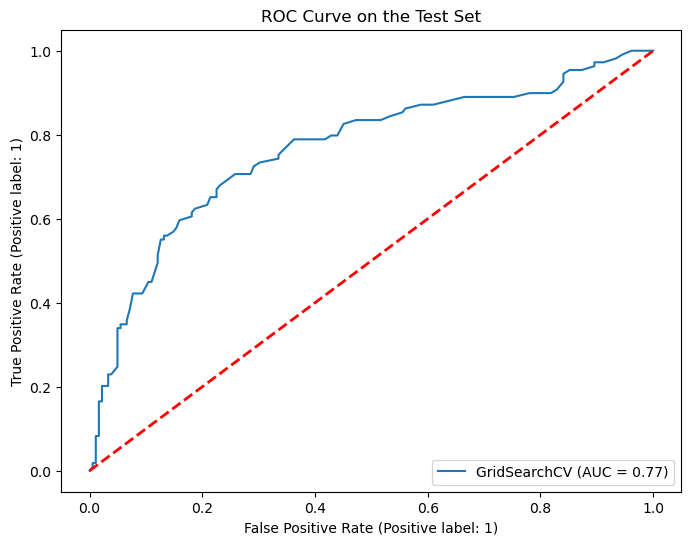

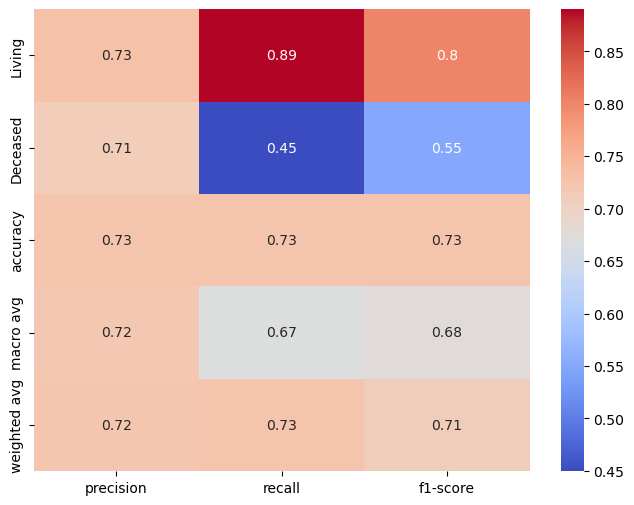

In [47]:
X = merge['clin'].select_dtypes(include=[float,int]).drop(columns=['OS_STATUS','OS_MONTHS']).fillna(-1)
y = merge['clin']['OS_STATUS']
labels = ['Living', 'Deceased']

clin_grid, clin_report, clin_conf_mat_fig, clin_best_est_roc = run_report_pipe(X,y,labels)

In [48]:
native_clin_scores = feat_imp_helper(X.columns,clin_grid.best_estimator_.named_steps["clf"].feature_importances_)
display(native_clin_scores)

Feature  Importance_Score
3                         TMB_NONSYNONYMOUS          0.161117
1                          MSI_SCORE_MANTIS          0.150399
8             PERSON_NEOPLASM_CANCER_STATUS          0.148094
4                                       AGE          0.134321
0                          ANEUPLOIDY_SCORE          0.121210
2                          MSI_SENSOR_SCORE          0.098301
7   NEW_TUMOR_EVENT_AFTER_INITIAL_TREATMENT          0.078572
10                        RADIATION_THERAPY          0.029997
5                                       SEX          0.025474
9                                  PRIOR_DX          0.017230
11                          PATH_T_STAGE_TX          0.017003
12    AJCC_PATHOLOGIC_TUMOR_STAGE_STAGE III          0.016792
6                 HISTORY_NEOADJUVANT_TRTYN          0.001491

Best cross-validation accuracy: 0.74
Test set score: 0.72
Best parameters: {'clf': RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=50), 'clf__class_weight': 'balanced', 'clf__max_depth': 5, 'clf__max_features': 'sqrt', 'clf__n_estimators': 50, 'dimred': PCA(n_components=6, random_state=42), 'dimred__n_components': 6, 'preprocessing': None}


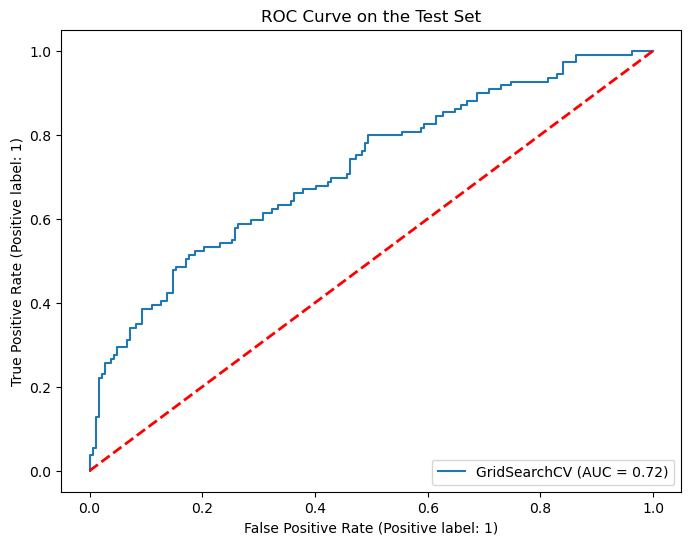

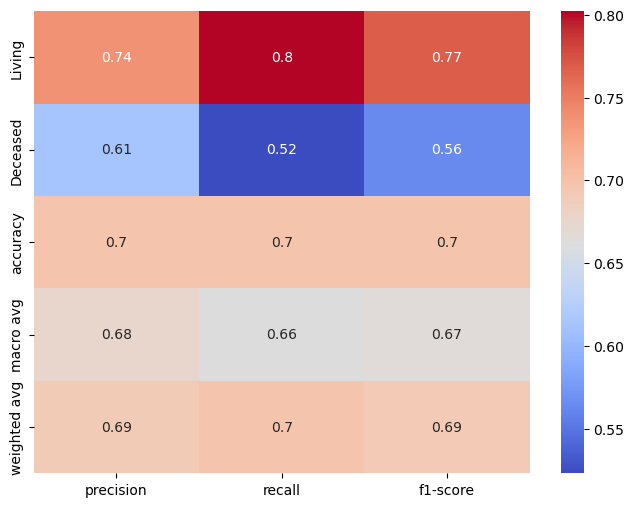

In [49]:
X = merge['clin'].select_dtypes(include=[float,int]).drop(columns=['OS_STATUS','OS_MONTHS']).fillna(-1)
y = merge['clin']['OS_STATUS']
labels = ['Living', 'Deceased']

clin_pca_grid, clin_pca_report, clin_pca_conf_mat_fig, clin_pca_best_est_rocc = run_report_linDR_pipe(X,y,labels)

In [52]:
clin_pca_grid.best_estimator_.named_steps["dimred"].n_components_

6

In [53]:
clin_pca_grid.best_estimator_.named_steps["dimred"].explained_variance_

array([102.78014701,  68.32412179,  47.14920832,   0.73902411,
         0.65365107,   0.49178951])

In [ ]:
#next we want to look at the mutations and RNA-expression (together and separately) using
#feat selection, PCA, and UMAP to do some dimensionality reduction 

[Text(0.5, 1.0, 'LUAD/LUSC Genetic Mutations T-SNE projection')]

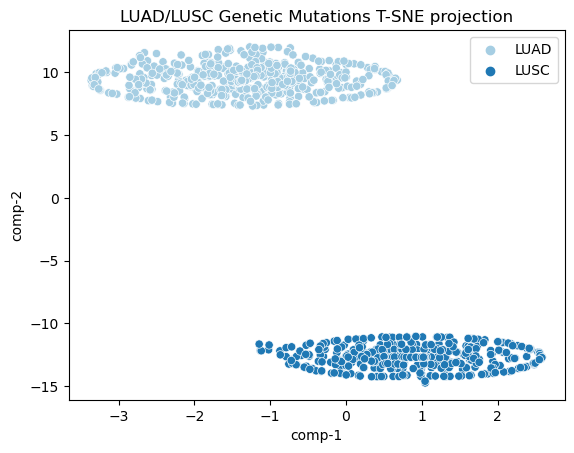

In [54]:
#let's take a closer look at the mutations -- #can we use genetic mutations to distinguish between LUAD and LUSC?  

X = merge['mutations'].fillna(-1).drop(columns=['ONCOTREE_CODE'])
y = merge['mutations']['ONCOTREE_CODE']

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
# use fit_transform instead of fit, as TSNE has no transform method
muts_tsne = tsne.fit_transform(X)

tsne_rez = pd.DataFrame()
tsne_rez["y"] = y
tsne_rez["comp-1"] = muts_tsne[:,0]
tsne_rez["comp-2"] = muts_tsne[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=tsne_rez.y.tolist(),
                palette=sns.color_palette("Paired", 2),
                data=tsne_rez).set(title="LUAD/LUSC Genetic Mutations T-SNE projection") 

In [55]:
#clear distinction on tSNE -- can they classify LUAD vs. LUSC in an RFC?

subtype_test = pd.merge(merge['mutations'].fillna(-1),
        merge['clin'][['SAMPLE_ID','ONCOTREE_CODE']],
         left_on=merge['mutations'].index,
         right_on='SAMPLE_ID'
        ).drop(columns=['SAMPLE_ID'])

subtype_test.head()

5S_rRNA  A1BG  A1BG-AS1  A1CF  A2M  A2ML1  A3GALT2  A4GALT  A4GNT  AAAS  \
0        0     0         0     0    0      0        0       0      0     0   
1        0     1         0     0    0      0        0       0      0     0   
2        0     0         0     0    0      0        0       0      0     0   
3        0     0         0     1    0      0        0       0      0     0   
4        0     0         0     0    0      0        0       0      0     0   

   ...  ZNF696  ZNF785  ZNF815P  ZNF888  ZNRF2  ZSCAN23  ZSWIM6  ZYG11A  \
0  ...      -1      -1       -1      -1     -1       -1      -1      -1   
1  ...      -1      -1       -1      -1     -1       -1      -1      -1   
2  ...      -1      -1       -1      -1     -1       -1      -1      -1   
3  ...      -1      -1       -1      -1     -1       -1      -1      -1   
4  ...      -1      -1       -1      -1     -1       -1      -1      -1   

   snoU13  ONCOTREE_CODE_y  
0      -1             LUAD  
1      -1             LUAD  
2      -1             LUAD  
3      -1             LUAD  
4      -1             LUAD  

[5 rows x 19861 columns]

Best cross-validation accuracy: 1.00
Test set score: 1.00
Best parameters: {'clf': RandomForestClassifier(class_weight='balanced', max_depth=1, max_features=2,
                       n_estimators=5), 'clf__class_weight': 'balanced', 'clf__max_depth': 1, 'clf__max_features': 2, 'clf__n_estimators': 5, 'preprocessing': StandardScaler()}


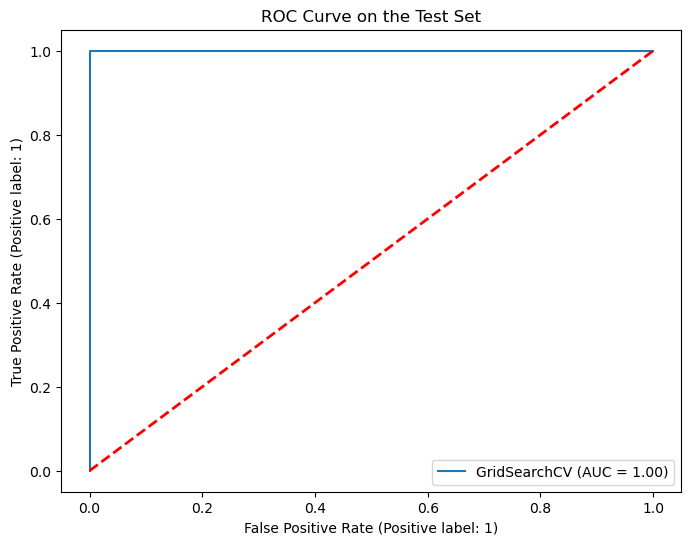

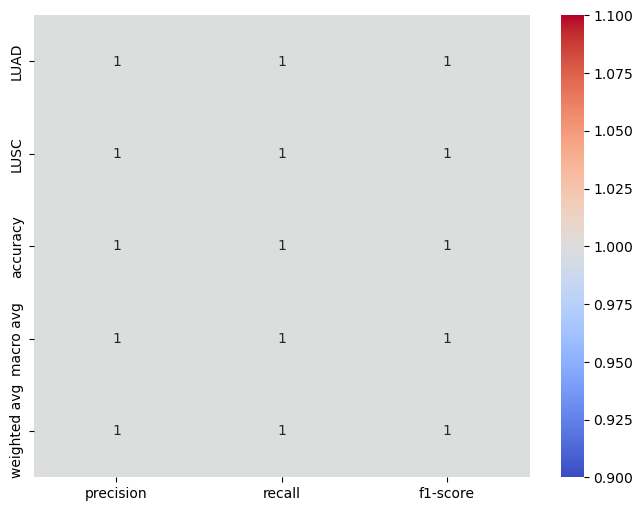

In [56]:
X = subtype_test[unique_genes]
y = subtype_test['ONCOTREE_CODE_y'].replace({'LUAD': 0, 'LUSC': 1})
labels = ['LUAD', 'LUSC']

st_grid, st_report, st_conf_mat_fig, st_best_est_roc = run_report_pipe(X,y,labels)

In [57]:
display(feat_imp_helper(X.columns,st_grid.best_estimator_.named_steps["clf"].feature_importances_))

Feature  Importance_Score
265         LYPLA1               0.2
936          CTXN3               0.2
1395       RIPPLY3               0.2
1103     KRTAP20-2               0.2
1495        SMIM14               0.2
...            ...               ...
562        SNORA76               0.0
561       SNORA70B               0.0
560        SNORA70               0.0
559        SNORA69               0.0
1694  hsa-mir-892c               0.0

[1695 rows x 2 columns]

In [58]:
os_status = pd.merge(merge['mutations'].fillna(-1),
        merge['clin'][['SAMPLE_ID','OS_STATUS']],
         left_on=merge['mutations'].index,
         right_on='SAMPLE_ID'
        ).drop(columns=['SAMPLE_ID','ONCOTREE_CODE'])

os_status.head()

5S_rRNA  A1BG  A1BG-AS1  A1CF  A2M  A2ML1  A3GALT2  A4GALT  A4GNT  AAAS  \
0        0     0         0     0    0      0        0       0      0     0   
1        0     1         0     0    0      0        0       0      0     0   
2        0     0         0     0    0      0        0       0      0     0   
3        0     0         0     1    0      0        0       0      0     0   
4        0     0         0     0    0      0        0       0      0     0   

   ...  ZNF696  ZNF785  ZNF815P  ZNF888  ZNRF2  ZSCAN23  ZSWIM6  ZYG11A  \
0  ...      -1      -1       -1      -1     -1       -1      -1      -1   
1  ...      -1      -1       -1      -1     -1       -1      -1      -1   
2  ...      -1      -1       -1      -1     -1       -1      -1      -1   
3  ...      -1      -1       -1      -1     -1       -1      -1      -1   
4  ...      -1      -1       -1      -1     -1       -1      -1      -1   

   snoU13  OS_STATUS  
0      -1          0  
1      -1          0  
2      -1          1  
3      -1          0  
4      -1          0  

[5 rows x 19860 columns]

In [59]:
print(f"From {os_status.shape[1]} genes to {len(unique_genes)} genes")

From 19860 genes to 1695 genes


Best cross-validation accuracy: 0.57
Test set score: 0.55
Best parameters: {'clf': RandomForestClassifier(class_weight='balanced', max_depth=2, max_features=5,
                       n_estimators=150), 'clf__class_weight': 'balanced', 'clf__max_depth': 2, 'clf__max_features': 5, 'clf__n_estimators': 150, 'preprocessing': None}


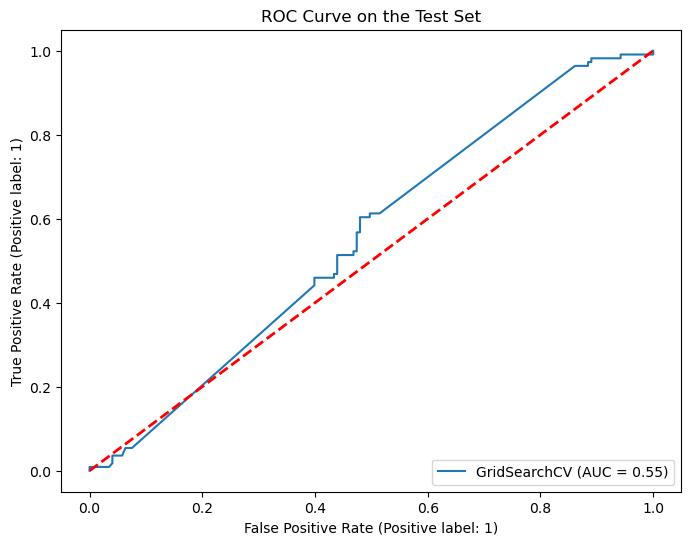

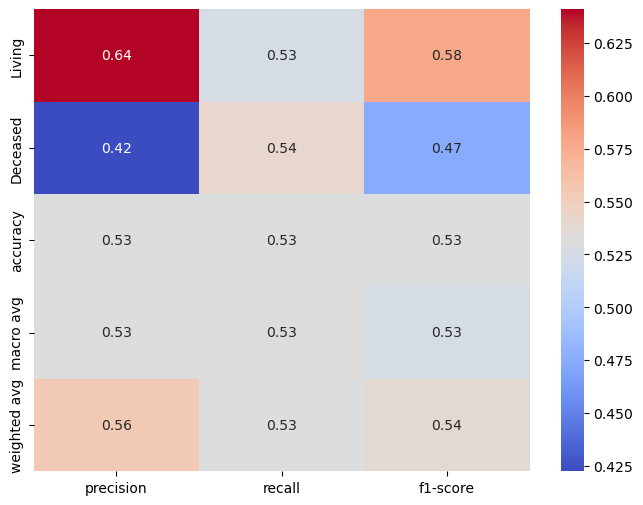

In [60]:
#feature selection strategy 1: the differential mutations seem to clearly distinguish LUAD+LUSC in tSNE and 
#in a RFC, #but do they help predict OS_STATUS?

X = os_status[unique_genes]
y = os_status['OS_STATUS']
labels = ['Living', 'Deceased']

native_mut_grid, native_mut_report, native_mut_fig, native_mut_roc = run_report_pipe(X,y,['Living', 'Deceased'])

#my interpretation of these results is that it is difficult for the model to use just mutations
#to distinguish between OS_STATUS. I think it is partly due to small differences in OS_STATUS within
#each LUAD and LUSC cohort. second, I think it is due to an incredible amount of noise in the mutation matrix, 
#even when I reduced it from ~19k to ~1.5k features. Many more mutations here each probably
#play a miniscule role in contributing to OS_STATUS. It is also possible that the
#random forest classifier isn't accomodating this many sparse features as well as a penalized Logistic Regression
#model would. if the dimensionality reduction pipeline demonstrates better performance than this subset, 
#I would be inclined to conclude this supports my hypotheses here.

In [61]:
native_mut_scores = feat_imp_helper(X.columns,native_mut_grid.best_estimator_.named_steps["clf"].feature_importances_)
display(native_mut_scores.head(20)) #we can see from this rundown that many genes are probably each playing a 
#very small role in differentiating between OS_STATUS classes

Feature  Importance_Score
1490     SLC25A44          0.012506
80      CCDC144CP          0.009816
584       SNORD16          0.008263
736         ZNRF2          0.007419
1538  SNORD115-38          0.007322
362        MIR720          0.007245
241        KCTD21          0.007205
1504      SNORA2B          0.006894
561      SNORA70B          0.006880
76        C9orf69          0.006749
441         PRR18          0.006255
287      MIR125B2          0.006240
613   SPTY2D1-AS1          0.006101
1672        VPS36          0.005933
688      TVP23CP2          0.005910
1492   SLC8A1-AS1          0.005872
939      CYB561D1          0.005778
1279       NBPF11          0.005725
673        TRAJ53          0.005631
193          GSC2          0.005562

Best cross-validation accuracy: 0.55
Test set score: 0.48
Best parameters: {'clf': RandomForestClassifier(class_weight='balanced', max_depth=2, max_features=0.3,
                       n_estimators=5), 'clf__class_weight': 'balanced', 'clf__max_depth': 2, 'clf__max_features': 0.3, 'clf__n_estimators': 5, 'dimred': PCA(n_components=2, random_state=42), 'dimred__n_components': 2, 'preprocessing': None}
CPU times: user 34.7 s, sys: 1.94 s, total: 36.6 s
Wall time: 28min 48s


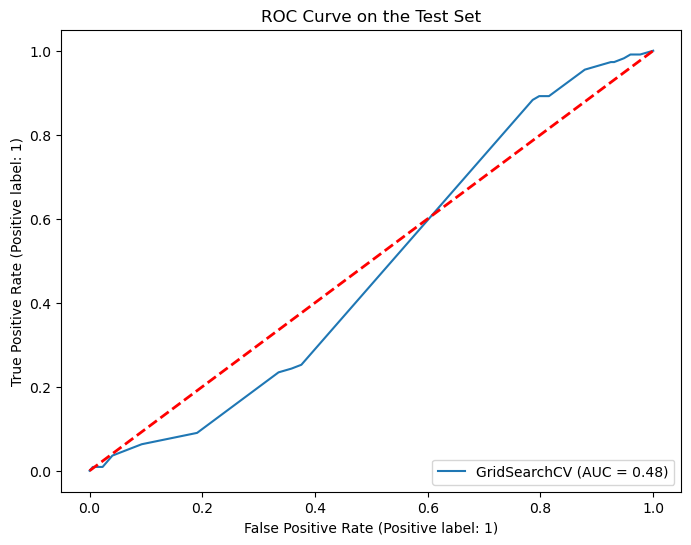

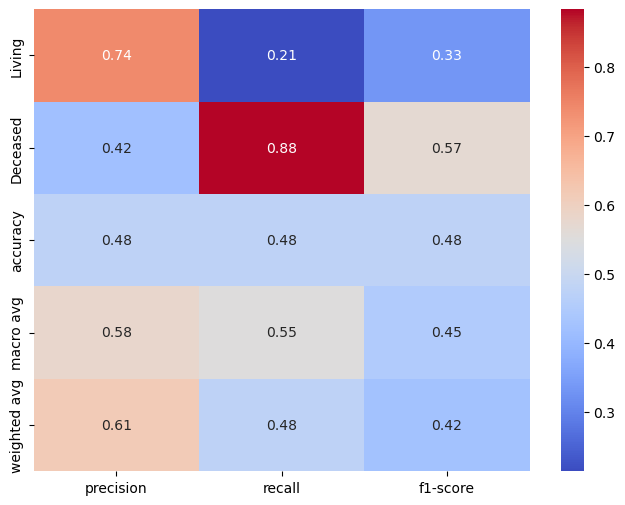

In [62]:
%%time

X = os_status.drop(columns=['OS_STATUS'])
y = os_status['OS_STATUS']

mut_pca_grid, mut_pca_report, mut_pca_fig, mut_pca_roc = run_report_linDR_pipe(X,y,['Living', 'Deceased'])

In [63]:
#the model with PCs of the genetic mutations as input isn't very good! 
mut_pca_grid.best_estimator_.named_steps["dimred"].explained_variance_.sum()

456.8426484471692

Best cross-validation accuracy: 0.56
Test set score: 0.54
Best parameters: {'clf': RandomForestClassifier(class_weight='balanced', max_depth=1, max_features=0.5,
                       n_estimators=150), 'clf__class_weight': 'balanced', 'clf__max_depth': 1, 'clf__max_features': 0.5, 'clf__n_estimators': 150, 'dimred': UMAP(n_neighbors=2, random_state=42), 'dimred__n_neighbors': 2, 'preprocessing': None}


NameError: name 'feat_imps' is not defined

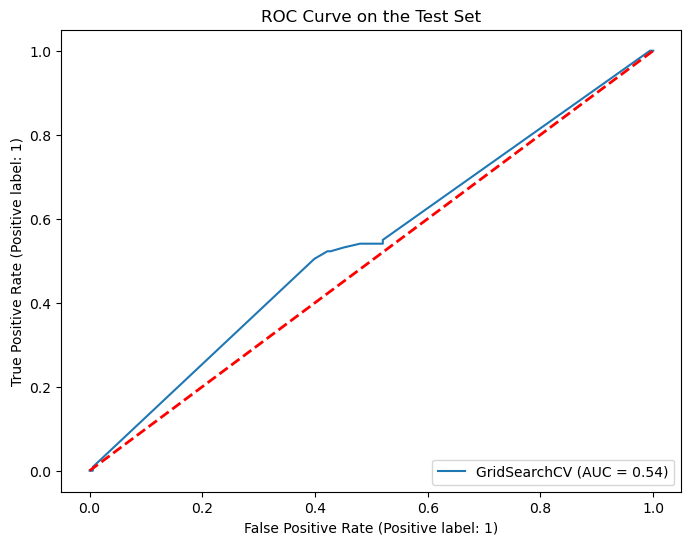

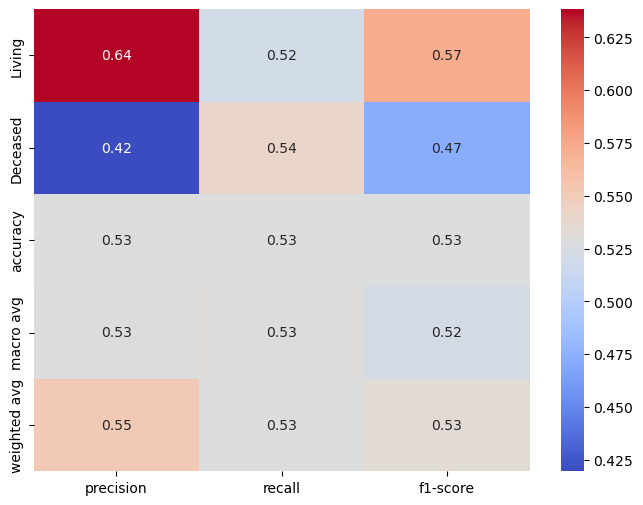

In [64]:
%%time
#import umap.plot
#open github bug:https://github.com/ratschlab/HIRID-ICU-Benchmark/issues/16
#Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.

#reducer = umap.UMAP().fit(X)
#umap.plot.connectivity(reducer)
umap_mut_grid, umap_mut_report, umap_mut_fig, umap_mut_roc = run_report_nonlinDR_pipe(X,y,labels)

In [65]:
#quick double check on shapes -- I previously checked in depth that this merge should be fine to proceed 
#no duplicates of SAMPLE_ID in either df, so an inner merge would lose some data but ultimately yield 1-1 mappings
#the samples df is bigger than the clinical df because we dropped NaN values in the clinical df previously, 
#and did not explicitly coordinate dropping those sample SAMPLE_IDS with samples df or mutations df until now 

print(merge['clin'].shape,merge['clin']['SAMPLE_ID'].nunique())
print(merge['samples'].shape, merge['samples'].index.nunique())

(967, 53) 967
(994, 20215) 994


In [66]:
merge['samples'].head()

key_0           UBE2Q2P2 HMGB1P1 RNU12-2P   SSX9P   EZHIP  EFCAB8 SRP14P1  \
SAMPLE_ID                                                                   
TCGA-05-4244-01   0.0641 -1.9056   0.5509 -1.2501 -0.9546  1.4019  0.1057   
TCGA-05-4249-01   0.1921 -0.2903   1.4724 -1.2501 -0.9546 -0.2801 -0.0095   
TCGA-05-4250-01  -0.7281  -1.909  -2.1684 -1.2501 -0.9546 -1.6683 -0.0589   
TCGA-05-4382-01  -0.4447 -0.5293   -0.684 -0.9868  1.2012  -0.175 -0.2588   
TCGA-05-4384-01  -1.3592 -0.8865  -0.3588 -1.2501 -0.9546 -0.3293  0.2349   

key_0           TRIM75P SDR16C6P HSPB1P1  ... SNAR-E SNORA36B SNORA69  \
SAMPLE_ID                                 ...                           
TCGA-05-4244-01 -2.3173   -2.543  0.5735  ...    NaN      NaN     NaN   
TCGA-05-4249-01 -2.3173   -2.543 -1.1613  ...    NaN      NaN     NaN   
TCGA-05-4250-01 -2.3173   -2.543  0.0932  ...    NaN      NaN     NaN   
TCGA-05-4382-01  -1.231   -2.543 -0.0164  ...    NaN      NaN     NaN   
TCGA-05-4384-01 -2.3173   -2.543 -0.4549  ...    NaN      NaN     NaN   

key_0           SNORD115-13 SNORD115-7 TAS2R16 TTTY18 TTTY23 TTTY3B UNCX  
SAMPLE_ID                                                                 
TCGA-05-4244-01         NaN        NaN     NaN    NaN    NaN    NaN  NaN  
TCGA-05-4249-01         NaN        NaN     NaN    NaN    NaN    NaN  NaN  
TCGA-05-4250-01         NaN        NaN     NaN    NaN    NaN    NaN  NaN  
TCGA-05-4382-01         NaN        NaN     NaN    NaN    NaN    NaN  NaN  
TCGA-05-4384-01         NaN        NaN     NaN    NaN    NaN    NaN  NaN  

[5 rows x 20215 columns]

In [67]:
rna_os_status = pd.merge(merge['samples'],
          merge['clin'][['SAMPLE_ID','OS_STATUS']],
          left_on=merge['samples'].index,
          right_on='SAMPLE_ID'
         ).drop(columns=['ONCOTREE_CODE','SAMPLE_ID'])

display(rna_os_status.head())
print(rna_os_status.shape)

UBE2Q2P2 HMGB1P1 RNU12-2P   SSX9P   EZHIP  EFCAB8 SRP14P1 TRIM75P SDR16C6P  \
0   0.0641 -1.9056   0.5509 -1.2501 -0.9546  1.4019  0.1057 -2.3173   -2.543   
1   0.1921 -0.2903   1.4724 -1.2501 -0.9546 -0.2801 -0.0095 -2.3173   -2.543   
2  -0.7281  -1.909  -2.1684 -1.2501 -0.9546 -1.6683 -0.0589 -2.3173   -2.543   
3  -0.4447 -0.5293   -0.684 -0.9868  1.2012  -0.175 -0.2588  -1.231   -2.543   
4  -1.3592 -0.8865  -0.3588 -1.2501 -0.9546 -0.3293  0.2349 -2.3173   -2.543   

  HSPB1P1  ... SNORA36B SNORA69 SNORD115-13 SNORD115-7 TAS2R16 TTTY18 TTTY23  \
0  0.5735  ...      NaN     NaN         NaN        NaN     NaN    NaN    NaN   
1 -1.1613  ...      NaN     NaN         NaN        NaN     NaN    NaN    NaN   
2  0.0932  ...      NaN     NaN         NaN        NaN     NaN    NaN    NaN   
3 -0.0164  ...      NaN     NaN         NaN        NaN     NaN    NaN    NaN   
4 -0.4549  ...      NaN     NaN         NaN        NaN     NaN    NaN    NaN   

  TTTY3B UNCX OS_STATUS  
0    NaN  NaN         0  
1    NaN  NaN         0  
2    NaN  NaN         1  
3    NaN  NaN         0  
4    NaN  NaN         0  

[5 rows x 20215 columns]

(960, 20215)


In [68]:
luad_spec_rna, lusc_spec_rna = find_subtype_spec_muts(luad_proc['samples'].set_index('SAMPLE_ID').drop(columns=['TUMOR_TYPE','ONCOTREE_CODE']).T,
                                                      lusc_proc['samples'].set_index('SAMPLE_ID').drop(columns=['TUMOR_TYPE','ONCOTREE_CODE']).T)

In [69]:
unique_rna_exp = lusc_spec_rna+luad_spec_rna

Best cross-validation accuracy: 0.54
Test set score: 0.53
Best parameters: {'clf': RandomForestClassifier(class_weight='balanced', max_depth=5,
                       max_features='log2', n_estimators=5), 'clf__class_weight': 'balanced', 'clf__max_depth': 5, 'clf__max_features': 'log2', 'clf__n_estimators': 5, 'preprocessing': StandardScaler()}
CPU times: user 934 ms, sys: 47.2 ms, total: 982 ms
Wall time: 27.3 s


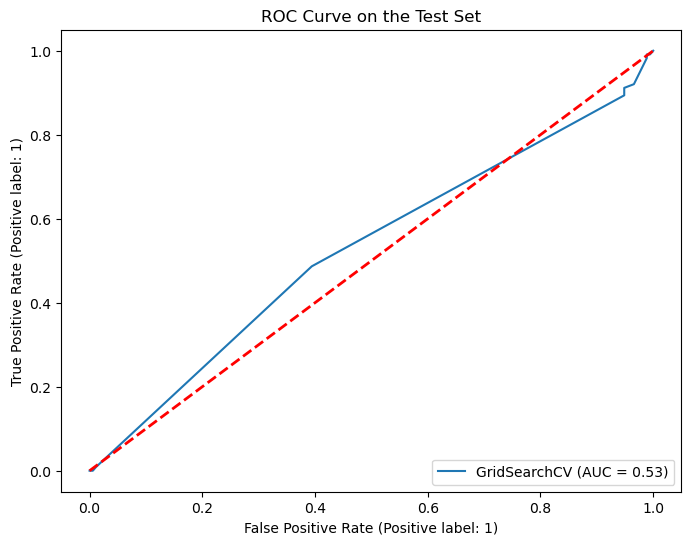

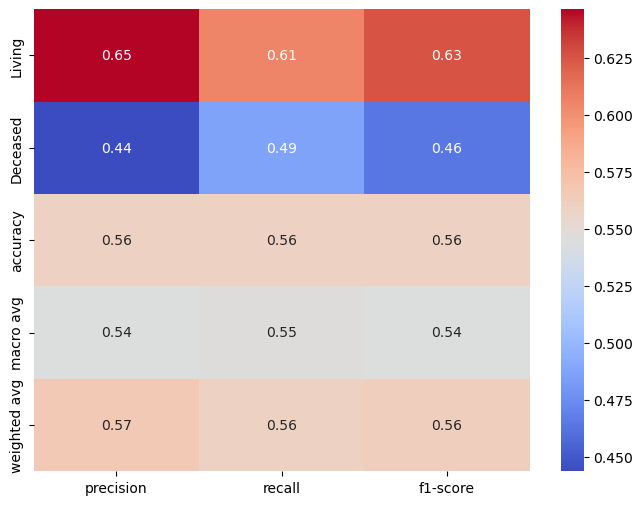

In [70]:
%%time
#what about gene expression of those mutations we saw earlier?

X = rna_os_status[unique_rna_exp].fillna(0)
y = rna_os_status['OS_STATUS']
labels = ['Living', 'Deceased']

rna_sub_grid, rna_sub_report, rna_sub_fig, rna_sub_roc = run_report_pipe(X,y,labels)

In [71]:
rna_sub_feat_imps = feat_imp_helper(X.columns,rna_sub_grid.best_estimator_.named_steps["clf"].feature_importances_)
display(rna_sub_feat_imps)

Feature  Importance_Score
90    RNASE12          0.105330
11   DEFB104A          0.094545
10       DAZ4          0.064514
70     OR5M10          0.056905
83      OR8H3          0.056399
..        ...               ...
48      OR2T1          0.000000
47     OR2T12          0.000000
46      OR2M2          0.000000
44      OR2G3          0.000000
128   ZCCHC13          0.000000

[129 rows x 2 columns]

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


Best cross-validation accuracy: 0.58
Test set score: 0.52
Best parameters: {'clf': RandomForestClassifier(class_weight='balanced', max_depth=1, max_features=2,
                       n_estimators=150), 'clf__class_weight': 'balanced', 'clf__max_depth': 1, 'clf__max_features': 2, 'clf__n_estimators': 150, 'dimred': PCA(n_components=9, random_state=42), 'dimred__n_components': 9, 'preprocessing': None}


/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embeddin

/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embeddin

/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embeddin

/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/

/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/umap/spectral.py:260: UserWarning: 

/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embeddin

/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embeddin

/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embeddin

/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embeddin

/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embeddin

/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embeddin

/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embeddin

/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embeddin

/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embeddin

/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embeddin

/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embeddin

/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embeddin

/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embeddin

/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embeddin

/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embeddin

/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/

/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embeddin

/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/Users/

/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embeddin

/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/umap/spectral.py:260: UserWarning: 

/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embeddin

/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embeddin

/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embeddin

/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embeddin

/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embeddin

/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embeddin

/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/Users/

/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embeddin

/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/erin/opt/miniconda3/envs/tgca_pancan/lib/python3.10/site-packages/sklearn/manifold/_spectral_embeddin

Best cross-validation accuracy: 0.60
Test set score: 0.55
Best parameters: {'clf': RandomForestClassifier(class_weight='balanced', max_depth=10, max_features=0.5,
                       n_estimators=50), 'clf__class_weight': 'balanced', 'clf__max_depth': 10, 'clf__max_features': 0.5, 'clf__n_estimators': 50, 'dimred': UMAP(n_neighbors=2, random_state=42), 'dimred__n_neighbors': 2, 'preprocessing': StandardScaler()}


NameError: name 'feat_imps' is not defined

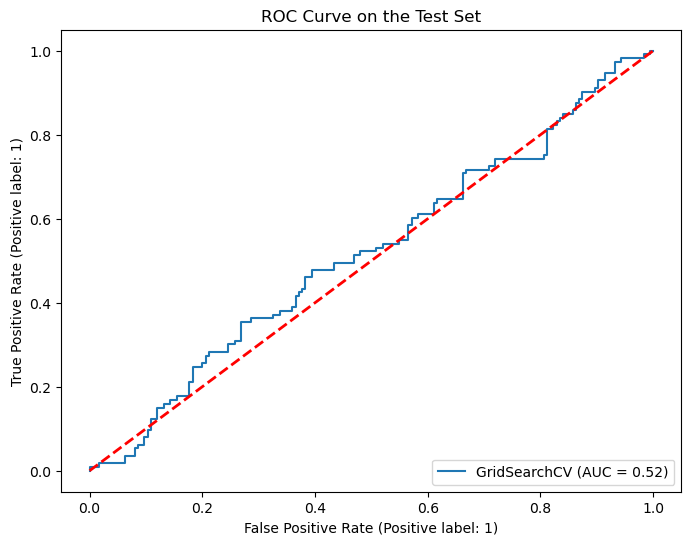

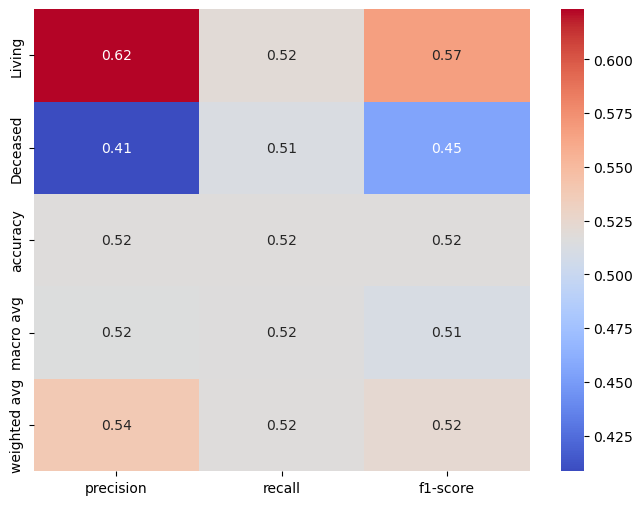

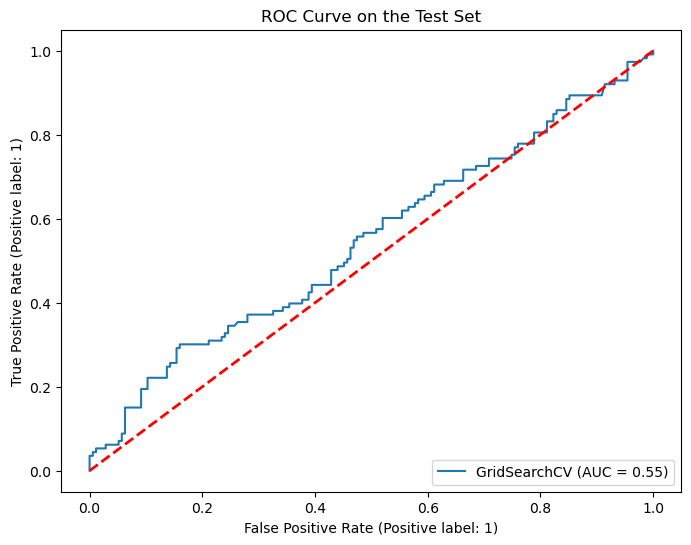

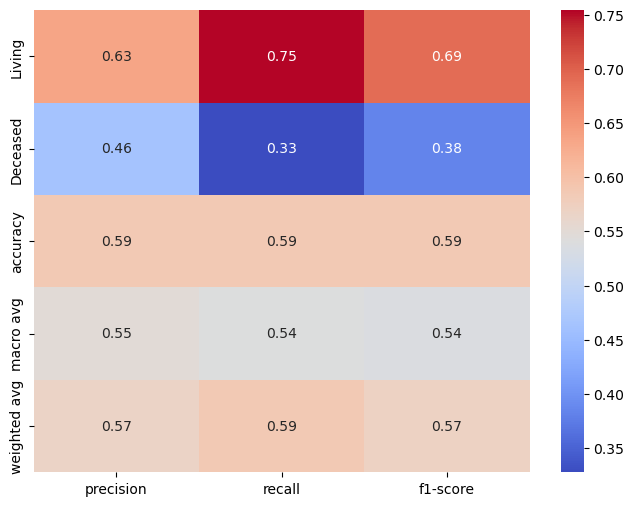

In [72]:
%%time
#trying PCA + UMAP pipes with rna gene expression now 

X = rna_os_status.fillna(0).drop(columns=['OS_STATUS'])
y = rna_os_status['OS_STATUS']

rna_pca_grid, rna_pca_report, rna_pca_fig, rna_pca_roc = run_report_linDR_pipe(X,y,labels)
rna_umap_grid, rna_umap_report, rna_umap_fig, rna_umap_roc = run_report_nonlinDR_pipe(X,y,labels)

In [74]:
#looking at mutations + RNA expression together as input features

#this merge will implicitly add suffixes here because of the duplicate columns (Hugo Symbol across
#RNA expr and genetic mutations)

gene_muts_expr = pd.merge(merge['mutations'].drop(columns=['ONCOTREE_CODE']),
                          merge['samples'],
                          left_on='SAMPLE_ID',
                          right_on='SAMPLE_ID')
gene_muts_expr_os = pd.merge(gene_muts_expr,
                            merge['clin'][['SAMPLE_ID','OS_STATUS']],
                            left_on=gene_muts_expr.index,
                            right_on='SAMPLE_ID').drop(columns=['ONCOTREE_CODE','SAMPLE_ID'])
gene_muts_expr_os

5S_rRNA A1BG_x A1BG-AS1 A1CF_x A2M_x A2ML1_x A3GALT2 A4GALT_x A4GNT_x  \
0         0      0        0      0     0       0       0        0       0   
1         0      1        0      0     0       0       0        0       0   
2         0      0        0      0     0       0       0        0       0   
3         0      0        0      1     0       0       0        0       0   
4         0      0        0      0     0       0       0        0       0   
..      ...    ...      ...    ...   ...     ...     ...      ...     ...   
933     NaN      1        0      0     0       0     NaN        0       0   
934     NaN      0        0      0     0       0     NaN        0       0   
935     NaN      0        0      0     0       0     NaN        0       0   
936     NaN      0        0      0     0       0     NaN        0       0   
937     NaN      0        0      0     1       0     NaN        0       0   

    AAAS_x  ... SNORA36B_y SNORA69_y SNORD115-13 SNORD115-7 TAS2R16_y  TTTY18  \
0        0  ...        NaN       NaN         NaN        NaN       NaN     NaN   
1        0  ...        NaN       NaN         NaN        NaN       NaN     NaN   
2        0  ...        NaN       NaN         NaN        NaN       NaN     NaN   
3        0  ...        NaN       NaN         NaN        NaN       NaN     NaN   
4        0  ...        NaN       NaN         NaN        NaN       NaN     NaN   
..     ...  ...        ...       ...         ...        ...       ...     ...   
933      0  ...   -12.9672  -57.6184     -2.7845    -1.4605   -1.5533 -1.8914   
934      0  ...   -12.9672  -57.6184     -2.7845    -1.4605   -1.5533 -1.8914   
935      0  ...   -12.9672  -57.6184     -2.7845    -1.4605   -1.5533 -1.8914   
936      0  ...   -12.9672  -57.6184     -2.7845    -1.4605   -1.5533 -1.8914   
937      0  ...   -12.9672  -57.6184     -2.7845    -1.4605   -1.5533 -1.8914   

     TTTY23  TTTY3B  UNCX_y OS_STATUS  
0       NaN     NaN     NaN         0  
1       NaN     NaN     NaN         0  
2       NaN     NaN     NaN         1  
3       NaN     NaN     NaN         0  
4       NaN     NaN     NaN         0  
..      ...     ...     ...       ...  
933 -1.5356 -2.8617 -0.5683         1  
934 -1.5356 -2.8617 -0.9477         1  
935 -1.5356 -2.8617 -0.9477         1  
936 -1.5356 -2.8617 -0.9477         1  
937 -1.5356 -2.8617 -0.9477         1  

[938 rows x 40074 columns]

In [75]:
print(len(unique_genes), sorted(unique_genes))

1695 ['5S_rRNA', 'A3GALT2', 'AACSP1', 'AAED1', 'AAMDC', 'AANAT', 'ABHD14A', 'AC000095.9', 'AC004603.4', 'AC004706.1', 'AC004980.7', 'AC005009.2', 'AC005042.4', 'AC007038.7', 'AC007879.6', 'AC007899.3', 'AC009892.10', 'AC011738.4', 'AC011893.3', 'AC015818.3', 'AC034220.3', 'AC034228.3', 'AC079586.1', 'AC079776.2', 'AC093642.5', 'AC104135.3', 'AC112229.4', 'AC116050.1', 'ACE3P', 'ACOT1', 'ACTL10', 'ACYP1', 'ADIRF', 'ADIRF-AS1', 'ADPGK', 'AFAP1-AS1', 'AGBL3', 'AGGF1P4', 'AGTRAP', 'AHSA1', 'AIF1', 'AIF1L', 'AKR1C3', 'AKR7A3', 'AL033381.1', 'AL136418.1', 'AL359736.1', 'AL592284.1', 'ALDH1L1-AS1', 'ALDOC', 'ALG1L11P', 'ANAPC11', 'ANAPC13', 'ANAPC16', 'ANKHD1-EIF4EBP3', 'ANKRD18DP', 'ANKRD19P', 'ANKRD20A19P', 'ANKRD20A2', 'ANKRD20A3', 'ANKRD30BP2', 'ANKRD62', 'ANP32B', 'ANXA8L1', 'AP000266.7', 'AP001347.6', 'AP001652.1', 'AP002387.1', 'AP2S1', 'AP4B1-AS1', 'APH1B', 'APLN', 'APOBEC3B-AS1', 'APOE', 'APOM', 'AREGB', 'ARF3', 'ARHGAP19-SLIT1', 'ARIH2OS', 'ARL8B', 'ARL9', 'ARMS2', 'ARPC5L', 'ARTN',

In [76]:
len(gene_muts_expr_os.filter(regex=r'_[x|y]|'.join(unique_genes)).columns)
#I cross-checked this list because I expected 21*2 + 1 columns
#regex is picking up 2 extra columns and I think it's because it's not anchored properly
#with a ^ to anchor at the start. but adding $ to anchor at the end did not fix it
#I'm not sure how to add  -- I will manually drop them for now 


2119

In [77]:
len(gene_muts_expr_os.filter(regex='_[x|y]$|'.join(unique_genes)).columns)

2119

In [78]:
print(len(unique_rna_exp), sorted(unique_rna_exp))

129 ['CDX4', 'CDY1', 'CDY1B', 'CSHL1', 'CSN1S2A', 'CT47A10', 'CT47A11', 'CT47A9', 'DAOA', 'DAZ4', 'DEFB104A', 'DEFB106A', 'DEFB107A', 'DEFB136', 'DUX4L2', 'FAM24A', 'FKSG73', 'FLJ44082', 'GLYCAM1', 'GPHB5', 'GSX1', 'KRTAP10-8', 'KRTAP12-3', 'KRTAP15-1', 'KRTAP19-4', 'KRTAP19-7', 'KRTAP2-4', 'KRTAP27-1', 'KRTAP6-1', 'LCE1D', 'LCE3B', 'LCE3C', 'LCE4A', 'LINC00608', 'LRRC30', 'NPS', 'OR10A7', 'OR10C1', 'OR10G9', 'OR10H3', 'OR10H4', 'OR10K1', 'OR10K2', 'OR10R2', 'OR10T2', 'OR11H1', 'OR1A1', 'OR1I1', 'OR1S2', 'OR2G3', 'OR2L8', 'OR2M2', 'OR2M7', 'OR2T1', 'OR2T12', 'OR2T35', 'OR2T6', 'OR2Y1', 'OR4C12', 'OR4C13', 'OR4C16', 'OR4C45', 'OR4D9', 'OR4K13', 'OR4K15', 'OR4K2', 'OR4M1', 'OR4Q3', 'OR4S1', 'OR4X1', 'OR51F1', 'OR51G1', 'OR51V1', 'OR52A1', 'OR52J3', 'OR5B17', 'OR5D13', 'OR5D14', 'OR5D16', 'OR5D18', 'OR5F1', 'OR5H15', 'OR5L1', 'OR5L2', 'OR5M10', 'OR5M3', 'OR5R1', 'OR5T1', 'OR6C1', 'OR6C65', 'OR6C74', 'OR6P1', 'OR6Q1', 'OR6X1', 'OR7A10', 'OR7A17', 'OR7G1', 'OR8H1', 'OR8H3', 'OR8J3', 'OR8K5'

In [83]:
intermed_gene_sub = gene_muts_expr_os.filter(regex='_[x|y]$|'.join(unique_genes))\
      #.drop(columns=['PCDH10_x','PCDH10_y','CTTN_x','CTTN_y','RTTN_x','RTTN_y'])
len(intermed_gene_sub.columns)

intermed_rna_sub = gene_muts_expr_os.filter(regex='_[x|y]$|'.join(unique_rna_exp))

Best cross-validation accuracy: 0.61
Test set score: 0.58
Best parameters: {'clf': RandomForestClassifier(class_weight='balanced', max_depth=2,
                       max_features='log2', n_estimators=50), 'clf__class_weight': 'balanced', 'clf__max_depth': 2, 'clf__max_features': 'log2', 'clf__n_estimators': 50, 'preprocessing': None}
CPU times: user 2.68 s, sys: 348 ms, total: 3.02 s
Wall time: 1min 39s


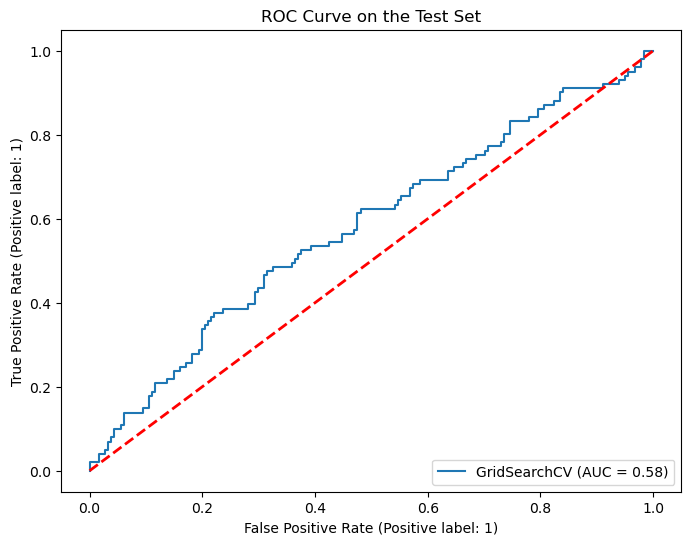

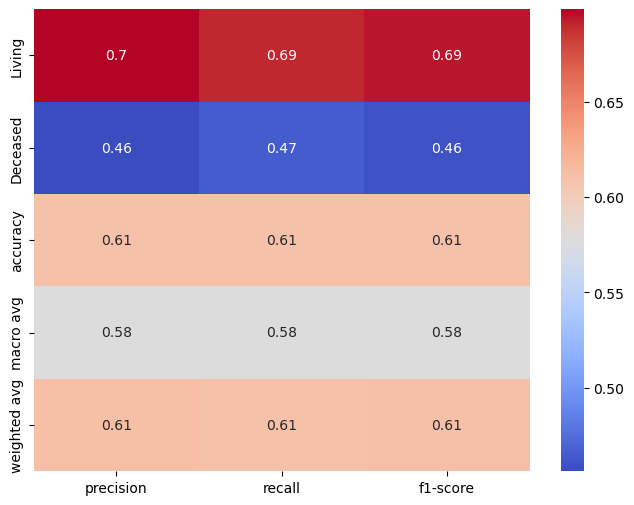

In [92]:
%%time
#native pipe test 

feats = pd.concat([intermed_rna_sub,intermed_gene_sub],axis=1).fillna(-1)
target = gene_muts_expr_os['OS_STATUS']
labels = ['Living', 'Deceased']

gme_sub_grid, gme_sub_report, gme_sub_fig, gme_sub_roc = run_report_pipe(feats,target,labels)


In [ ]:
%%time
#DR on larger Gene-Mutation Matrix
X = gene_muts_expr_os.drop(columns=['OS_STATUS']).fillna(-1)
y = gene_muts_expr_os['OS_STATUS']
labels = ['Living', 'Deceased']

gme_pca_grid, gme_pca_report, gme_pca_fig, gme_pca_roc = run_report_linDR_pipe(X,y,labels)
gme_umap_grid, gme_umap_report, gme_umap_fig, gme_umap_roc = run_report_nonlinDR_pipe(X,y,labels)

In [ ]:
#what features does minimum Redundancy - Maximum Relevance (mRMR) select from each, and how does it compare?
mrmr_sel_muts = mrmr_classif(X=os_status.drop(columns=['OS_STATUS']), y=os_status['OS_STATUS'], K=200)
mrmr_sel_rna = mrmr_classif(X=rna_os_status.fillna(0).drop(columns=['OS_STATUS']), y=rna_os_status['OS_STATUS'], K=200)
mrmr_sel_gme = mrmr_classif(X=gene_muts_expr.drop(columns=['OS_STATUS']), y=gene_muts_expr['OS_STATUS'], K=200)

# Appendix

In [ ]:
#not a ton of data for subtypes here -- it's tough to tell if there's any difference them
g = sns.displot(data=lusc_proc['sample'], x='ANEUPLOIDY_SCORE', col='TUMOR_TYPE', col_wrap=3, kde=True)

In [ ]:
#also tough to tell for LUAD subtypes -- the mixed subtype does look like it could be comprised of two groups 
g = sns.displot(data=luad_proc['sample'], x='ANEUPLOIDY_SCORE', col='TUMOR_TYPE', col_wrap=3, kde=True)